In [26]:
import torch
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import sys
import cv2
import os
import numpy as np
import torchvision
from pytorch_grad_cam import EigenCAM,EigenCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_accross_batch_and_channels , scale_cam_image
from config import *
from utils import *
from multiprocessing import Pool
import json
import pickle
import argparse 
import time
import random
import pytorch_grad_cam
%matplotlib inline
import matplotlib.pyplot as plt
from metric import *

## CODE TASK

### STEPS

1. Check if eigencam works on images without objects (It does !)
2. Test metrics
3. Central Extraction
4. Frontboard reduction(think mostly works, should be around 350 mark) (done)


In [5]:
image_indexes = [i for i in range(0,7501)]
video_indexes = [i for i in range(1,21)]
dataset = "./../DREYEVE_DATA_OUTPUT"

In [50]:
#Utilties 
#assumes both are int 


def load_image(img_path, transform = 1):
    """
    input is an image path and transform code
    returns an image corresponding to the path
    1 : BGR 2 RGB
    2 : BGR 2 GRAY
    3 : GRAY to GRAY
    """
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if transform == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif transform == 2:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

def show_images(images):
    """ given a list of images 
        shows the image in figure"""
    size = len(images)
    fig = plt.figure(figsize = (30,30))
    col = size // 2 + size % 2
    for i in range(size):
        fig.add_subplot(col,2,i + 1)
        img = images[i]
        if len(img.shape) == 3:
            plt.imshow(img)
        else:
            plt.imshow(img,cmap = "gray")
            
        
    
    
def get_image_pair_from_indexes(video_index, image_index):
    """ given an video index and image index, returns the garmnin and saliency image """
    video = str(video_index)
    if video_index < 10:
        video = "0" + str(video_index)
    image = str(image_index) + ".jpg"
    garmin_image_path = os.path.join(os.path.join(dataset,os.path.join(video,"garmin")),image)
    saliency_image_path = os.path.join(os.path.join(dataset,os.path.join(video,"saliency")),image)
    garmin_image = load_image(garmin_image_path, 1)
    saliency_image = load_image(saliency_image_path,1)
    
    return garmin_image, saliency_image

def get_random_image_pair():
    """ generates a random sample of the dataset """
    video_index = random.choice(video_indexes)
    image_index = random.choice(image_indexes)
    garmin, saliency = get_image_pair_from_indexes(video_index, image_index)
    return garmin, saliency

def get_random_images(num):
    """draws num samples of random"""
    img_pairs = []
    for i in range(num):
        garmin, saliency = get_random_image_pair()
        img_pairs.append([garmin, saliency])
    return img_pairs


def show_image_pairs(img_pairs):
    """ display list of image pairs """
    fig = plt.figure(figsize = (20,50))
    size = len(img_pairs)
    for i in range(size):
        garmin,saliency = img_pairs[i][0], img_pairs[i][1]
        fig.add_subplot(size,2,2*i + 1)
        plt.imshow(garmin)
        fig.add_subplot(size,2,2*i + 2)
        plt.imshow(saliency)
        
def draw_lines(img,height = 350):
    """ for experimentation, draws a thick line for removing the front cam """
    img[height-10:height+10,:,:] = 0
    return img
def draw_lines_img_pair(img_pair,height = 350):
    new_img_pair = []
    for images in img_pair:
        garmin,saliency = images[0],images[1]
        garmin = draw_lines(garmin,height)
        new_img_pair.append([garmin,saliency])
    return new_img_pair

def cut_image(img, height = 350):
    "to remove dashboard, cut the image below dashboard,provided height"
    new_img = np.zeros((height, img.shape[1], img.shape[2]),dtype = img.dtype)
    new_img = img[0:height,:,:]
    return new_img


        
        
        
        
    
    

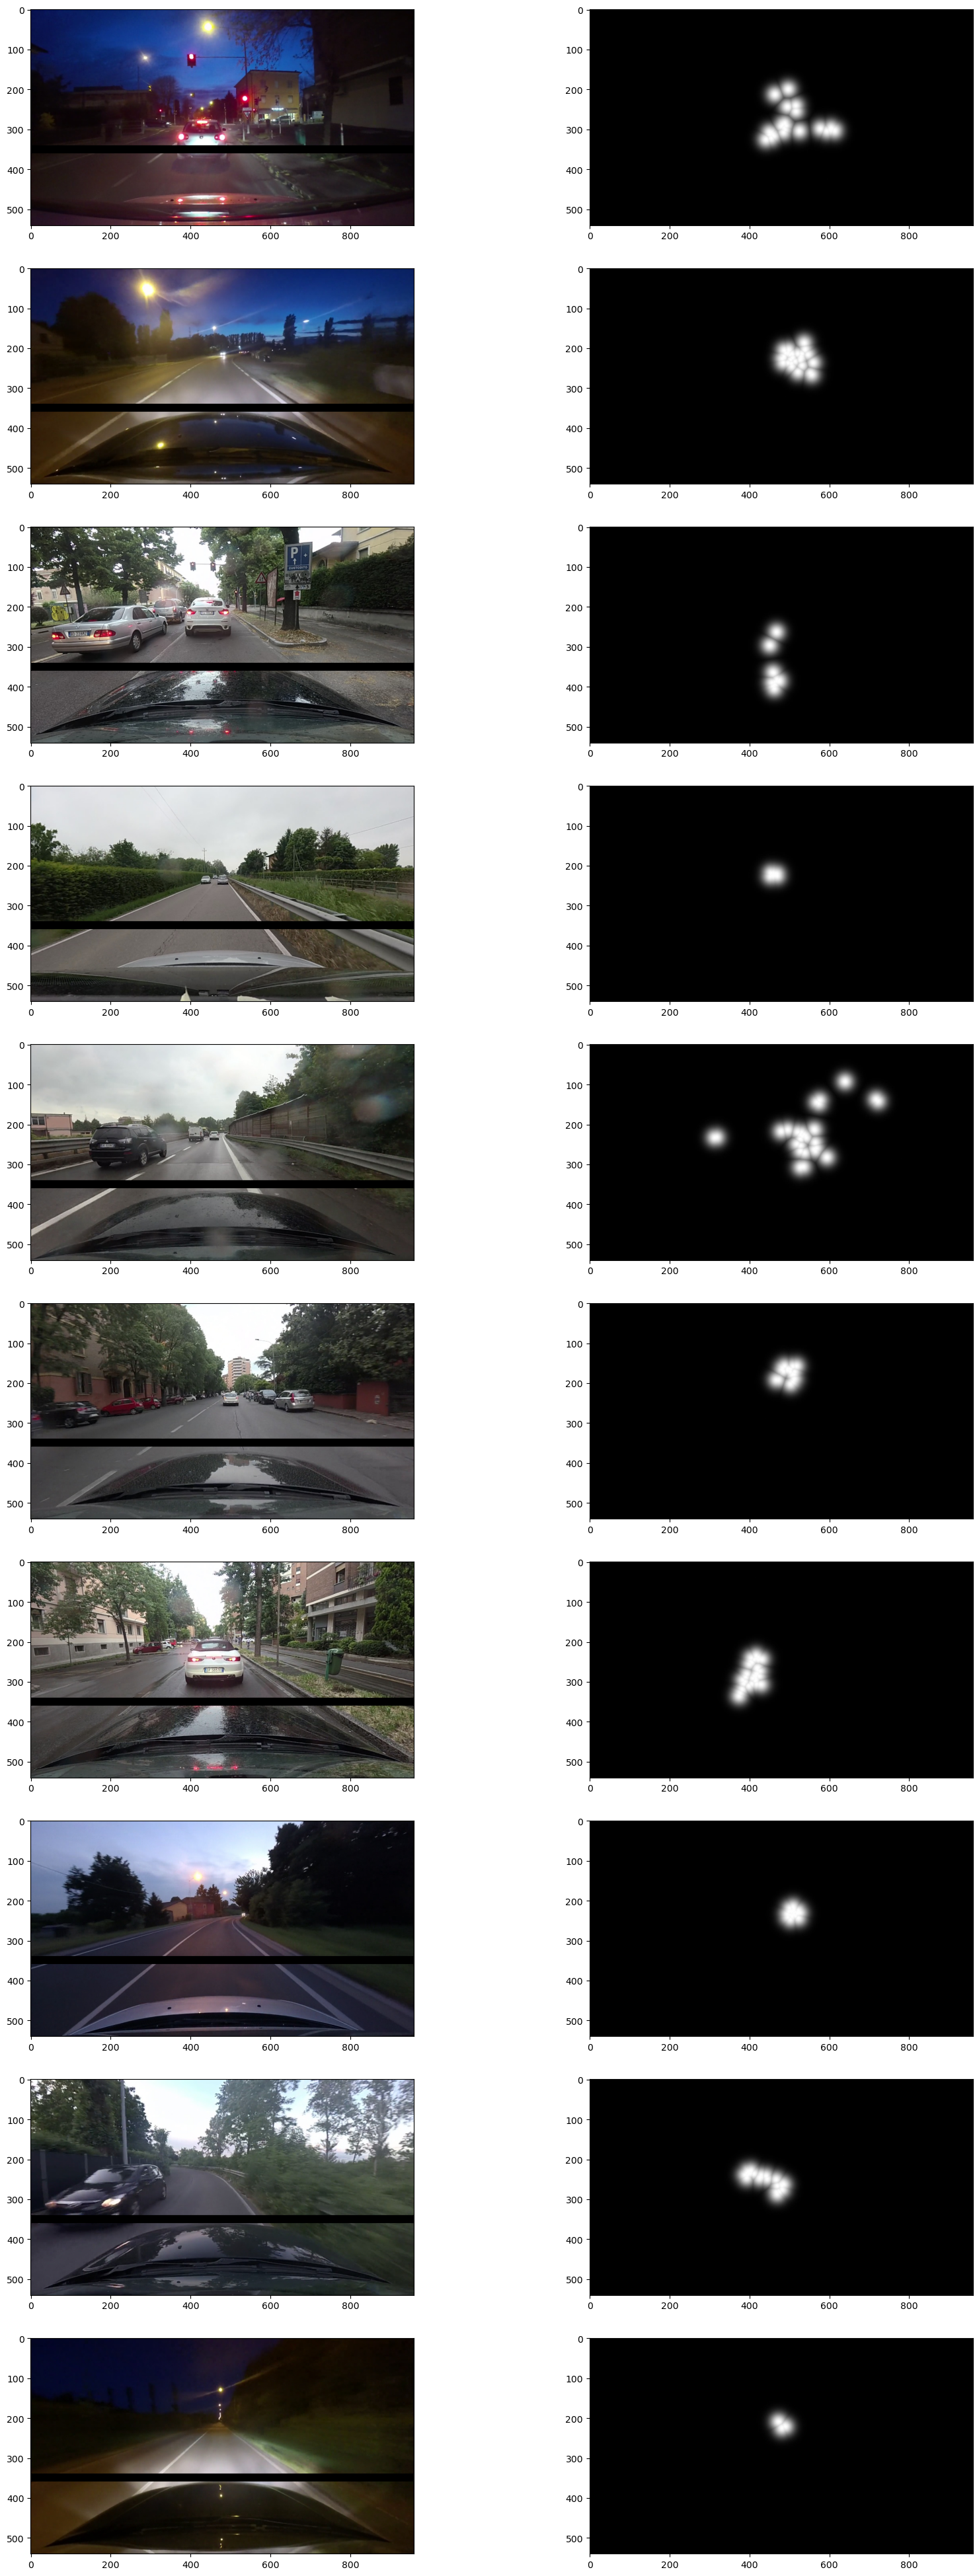

In [25]:
img_pair = get_random_images(10)
img_pair = draw_lines_img_pair(img_pair)
show_image_pairs(img_pair)

In [39]:
### Eigencam work

device = torch.device('cpu')
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
target_layers = [model.backbone]
cam = EigenCAM(model,target_layers, use_cuda = False  ,reshape_transform = fasterrcnn_reshape_transform)
model.eval().to(device)


def find_zero_object_image():
    cnt = 0
    while(True):
        cnt += 1
        #print(cnt)
        
        garmin,saliency = get_random_image_pair()
        img = garmin
        image_float_np = np.float32(img) / 255
        # define the torchvision image transforms
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
        ])

        input_tensor = transform(img)
        device = torch.device('cpu')
        #device = torch.device("cpu")
        input_tensor = input_tensor.to(device)
        # Add a batch dimension:
        input_tensor = input_tensor.unsqueeze(0)
        boxes, classes, labels, indices = predict(input_tensor, model, device , 0.7)
        num_objects = len(boxes)
        print("num objects : {0} iteration : {1} ".format(num_objects, cnt))
        if num_objects == 0:
            break
    return garmin,saliency
    
    

def generate_eigenmaps(img):


    image_float_np = np.float32(img) / 255
    # define the torchvision image transforms
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
    ])

    input_tensor = transform(img)
    device = torch.device('cpu')
    #device = torch.device("cpu")
    input_tensor = input_tensor.to(device)
    # Add a batch dimension:
    input_tensor = input_tensor.unsqueeze(0)
    boxes, classes, labels, indices = predict(input_tensor, model, device , 0.7)
    num_objects = len(boxes)
    box_image = draw_boxes(boxes,labels,classes,img)
    #target_layers = [model.backbone]
    targets = [FasterRCNNBoxScoreTarget(labels = labels,bounding_boxes = boxes)]
    grayscale_cam = cam(input_tensor, targets)
    grayscale_cam = grayscale_cam[0,:]
    final_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb = True)
    #save_RGB_image(box_image, box_path)
    #save_RGB_image(final_image, final_path)
    #cv2.imwrite(mask_path, grayscale_cam)
    #np.save(mask_path,grayscale_cam,allow_pickle = True)
    return grayscale_cam, box_image, final_image


In [40]:
g,s = find_zero_object_image()

1
2
3
4
5
6
7


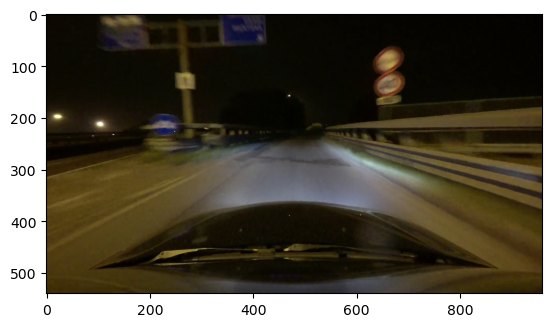

In [41]:
plt.imshow(g)

Number of objects : 0


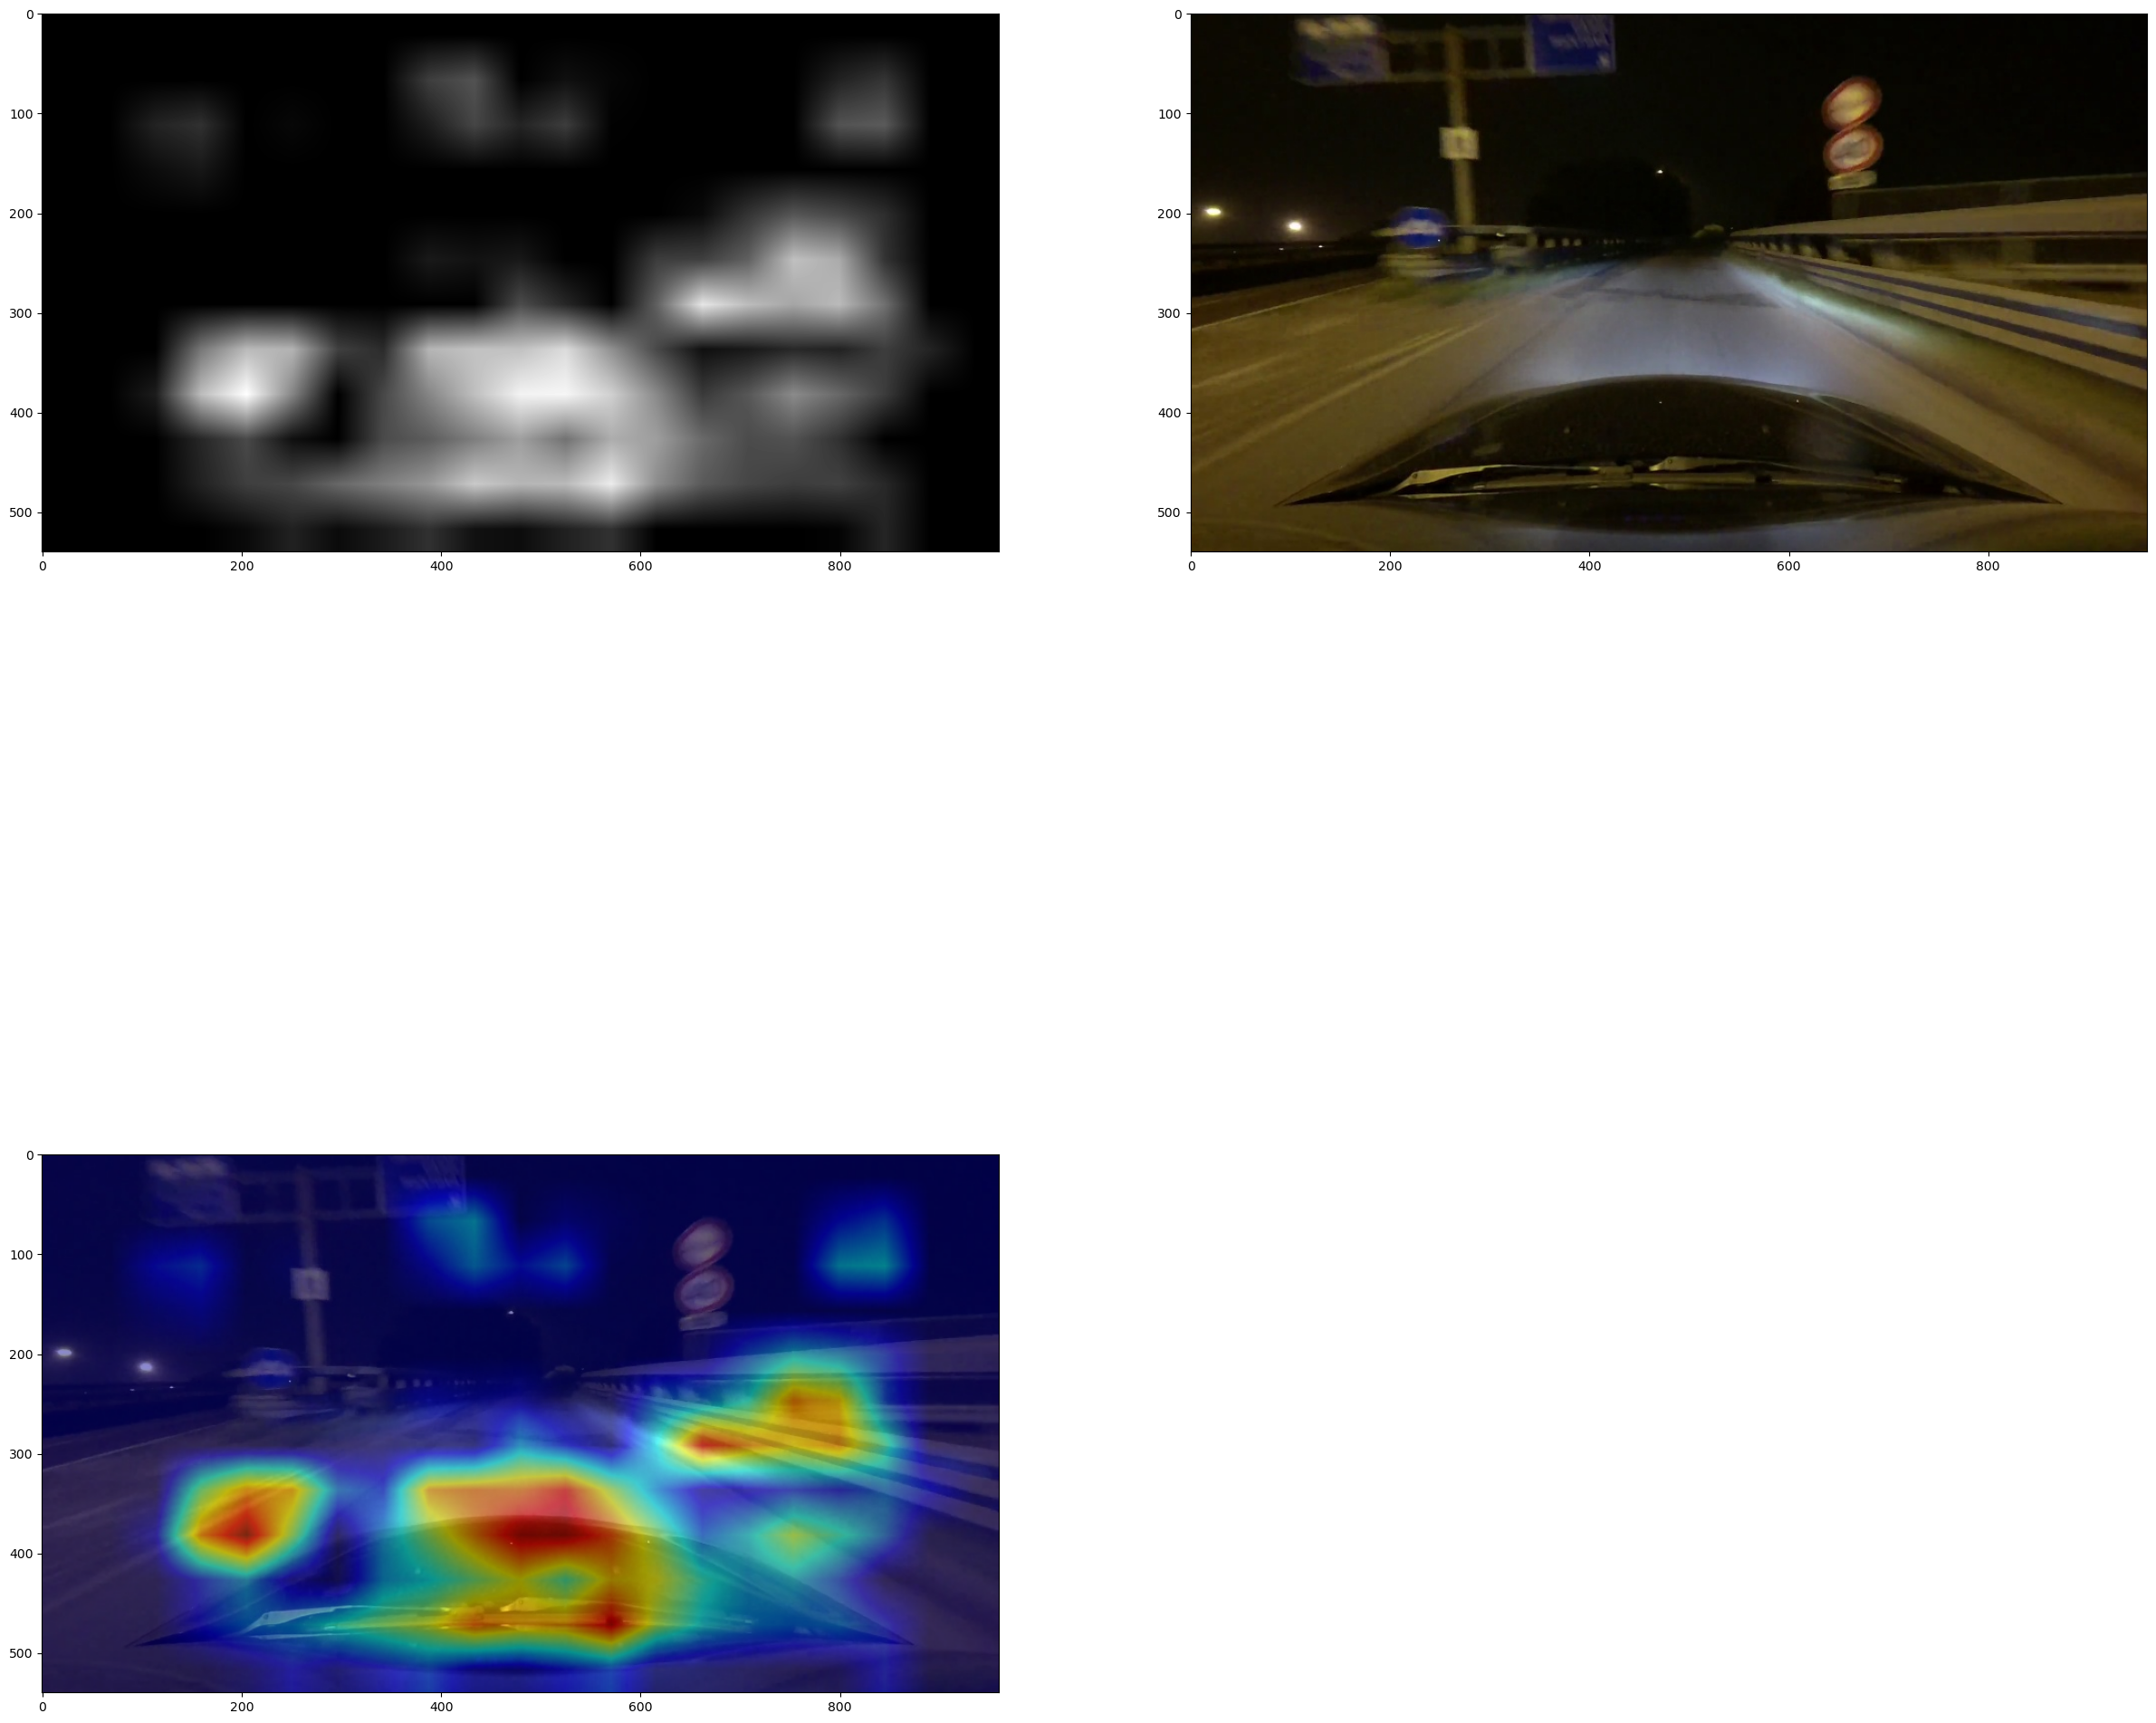

In [42]:
g,b,f = generate_eigenmaps(g)
show_images([g,b,f])

In [47]:
print(img_pair[0][0].shape)


(540, 960, 3)


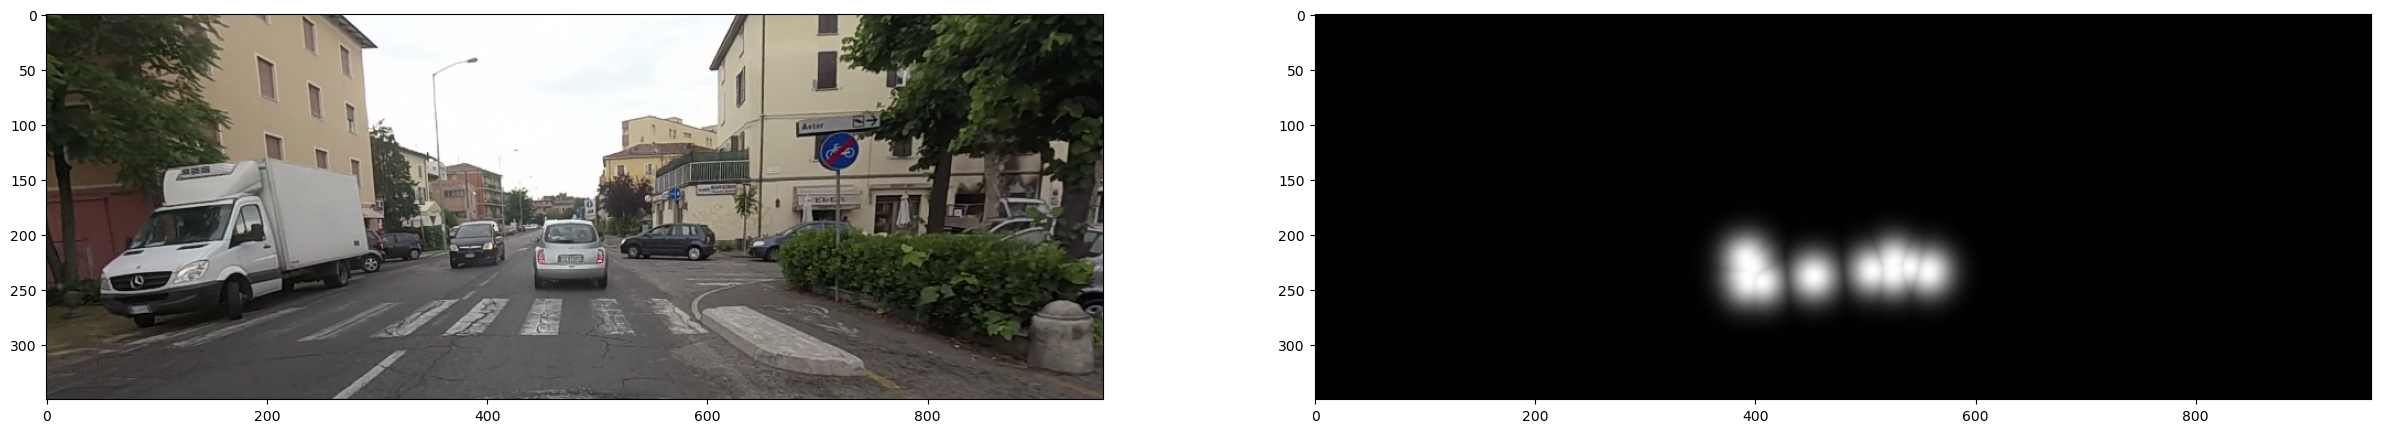

In [52]:
garmin, saliency  = get_random_image_pair()
garmin, saliency = cut_image(garmin), cut_image(saliency)
show_images([garmin, saliency])
